In [2]:
import oceanspy as ospy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap

plt.rcParams.update({
    'font.size': 11,       # Default text size
    'axes.titlesize': 10,  # Title size
    'axes.labelsize': 10,  # Axis label size
    'xtick.labelsize': 8, # X-tick label size
    'ytick.labelsize': 8, # Y-tick label size
    'legend.fontsize': 8, # Legend font size
    'figure.titlesize': 10 # Figure title size
})

In [3]:
df = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/Background_var.nc')
depth = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/Depth_res.nc')['Depth'].sel(Y=slice(66,79)).sel(X=slice(-30,10))
depth_notZero = depth
depth = depth.where(depth>=0,np.nan)
weights = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/weighted_mean_comp_cut.nc')

In [4]:
df

<xarray.Dataset>
Dimensions:    (Z: 216, Zp1: 217, Zu: 216, Zl: 216, X: 765, Y: 628, Xp1: 766,
                Yp1: 629, time: 12, time_midp: 11)
Coordinates: (12/18)
  * Z          (Z) float64 -1.0 -3.5 -7.0 ... -3.904e+03 -3.922e+03 -3.942e+03
  * Zp1        (Zp1) float64 0.0 -2.0 -5.0 ... -3.913e+03 -3.932e+03 -3.951e+03
  * Zu         (Zu) float64 -2.0 -5.0 -9.0 ... -3.913e+03 -3.932e+03 -3.951e+03
  * Zl         (Zl) float64 0.0 -2.0 -5.0 ... -3.894e+03 -3.913e+03 -3.932e+03
  * X          (X) float64 -29.92 -29.84 -29.76 -29.67 ... 11.72 11.82 11.92
  * Y          (Y) float64 65.01 65.03 65.04 65.06 ... 78.67 78.75 78.83 78.92
    ...         ...
  * time       (time) datetime64[ns] 2017-09-01 2017-10-01 ... 2018-08-01
    YU         (Y, Xp1) float64 ...
    XU         (Y, Xp1) float64 ...
    YV         (Yp1, X) float64 ...
    XV         (Yp1, X) float64 ...
  * time_midp  (time_midp) datetime64[ns] 2017-09-16 ... 2018-07-16T12:00:00
Data variables:
    U          (time, Z, Y, Xp1) float64 ...
    V          (time, Z, Yp1, X) float64 ...
    Temp       (time, Z, Y, X) float64 ...
    S          (time, Z, Y, X) float64 ...
    Eta        (time, Y, X) float64 ...
    MXLDEPTH   (time, Y, X) float64 ...
    SIarea     (time, Y, X) float64 ...
    SIheff     (time, Y, X) float64 ...
Attributes: (12/24)
    MITgcm_version:          checkpoint67l
    build_user:              malmans2@jhu.edu
    build_host:              compute0673
    build_date:              Fri Nov  8 01:36:45 EST 2019
    MITgcm_URL:              http://mitgcm.org
    MITgcm_tag_id:           
    ...                      ...
    OceanSpy_parameters:     {'rSphere': 6371.0, 'eq_state': 'mdjwf', 'rho0':...
    OceanSpy_name:           IGPyearlong
    OceanSpy_description:    High-resolution numerical simulation carried out...
    OceanSpy_projection:     Mercator(**{})
    OceanSpy_grid_coords:    {'Y': {'Y': None, 'Yp1': 0.5}, 'X': {'X': None, ...
    OceanSpy_grid_periodic:  []

In [5]:
U = df['U'].sel(Z=-50,method='nearest').sel(time=['2017-09-01T00:00:00.000000000','2018-02-01T00:00:00.000000000','2018-08-01T00:00:00.000000000'])
V = df['V'].sel(Z=-50,method='nearest').sel(time=['2017-09-01T00:00:00.000000000','2018-02-01T00:00:00.000000000','2018-08-01T00:00:00.000000000'])

U_mean = df['U'].sel(Z=-50,method='nearest').mean(dim='time')
V_mean = df['V'].sel(Z=-50,method='nearest').mean(dim='time')

In [6]:
# Create the target grid (X and Y) based on the midpoints of the staggered grid
X = df['X']
Y = df['Y']

# Interpolating U to the target grid (X, Y)
U_interp = U.interp(Xp1=X, Y=Y, method='linear')
U_interp_mean = U_mean.interp(Xp1=X, Y=Y, method='linear')

# Interpolating V to the target grid (X, Y)
V_interp = V.interp(X=X, Yp1=Y, method='linear')
V_interp_mean = V_mean.interp(X=X, Yp1=Y, method='linear')

# Drop the existing Y coordinate in V_interp to avoid conflicts
U_interp = U_interp.drop_vars('X')
V_interp = V_interp.drop_vars('Y')

U_interp_mean = U_interp_mean.drop_vars('X')
V_interp_mean = V_interp_mean.drop_vars('Y')

# Rename the dimensions and coordinates
U_interp = U_interp.rename({'Xp1': 'X'})
V_interp = V_interp.rename({'Yp1': 'Y'})

U_interp_mean = U_interp_mean.rename({'Xp1': 'X'})
V_interp_mean = V_interp_mean.rename({'Yp1': 'Y'})

# Ensure the coordinates are updated correctly
U_interp_r = U_interp.assign_coords(X=X, Y=Y)
V_interp_r = V_interp.assign_coords(X=X, Y=Y)

U_interp_mean_r = U_interp_mean.assign_coords(X=X, Y=Y)
V_interp_mean_r = V_interp_mean.assign_coords(X=X, Y=Y)

display(U_interp)

/tmp/ipykernel_2372316/3778480522.py:21: UserWarning: rename 'Xp1' to 'X' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  U_interp = U_interp.rename({'Xp1': 'X'})
/tmp/ipykernel_2372316/3778480522.py:22: UserWarning: rename 'Yp1' to 'Y' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  V_interp = V_interp.rename({'Yp1': 'Y'})
/tmp/ipykernel_2372316/3778480522.py:24: UserWarning: rename 'Xp1' to 'X' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  U_interp_mean = U_interp_mean.rename({'Xp1': 'X'})
/tmp/ipykernel_2372316/3778480522.py:25: UserWarning: rename 'Yp1' to 'Y' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  V_interp_mean = V_interp_mean.rename({'Yp1': 'Y'})


<xarray.DataArray 'U' (time: 3, Y: 628, X: 765)>
array([[[-0.12652373, -0.10026876, -0.0823844 , ...,         nan,
                 nan,         nan],
        [-0.13024236, -0.09970809, -0.08383596, ...,         nan,
                 nan,         nan],
        [-0.12875982, -0.10407657, -0.09307822, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.18383648, -0.13362678, -0.07457173, ...,         nan,
                 nan,         nan],
        [-0.21521705, -0.18163102, -0.12592639, ...,         nan,
                 nan,         nan],
        [-0.22199287, -0.21403069, -0.18760901, ...,         nan,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.15729407, -0.12271307, -0.0986229 , ...,         nan,
                 nan,         nan],
        [-0.15252166, -0.13359219, -0.11930422, ...,         nan,
                 nan,         nan],
        [-0.15511504, -0.1423716 , -0.15677902, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
    Z        float64 -49.0
  * time     (time) datetime64[ns] 2017-09-01 2018-02-01 2018-08-01
    YU       (Y, X) float64 65.01 65.01 65.01 65.01 ... 78.92 78.92 78.92 78.92
    XU       (Y, X) float64 -29.92 -29.84 -29.76 -29.67 ... 11.72 11.82 11.92
    X        (X) float64 -29.92 -29.84 -29.76 -29.67 ... 11.62 11.72 11.82 11.92
  * Y        (Y) float64 65.01 65.03 65.04 65.06 ... 78.67 78.75 78.83 78.92
Attributes:
    units:          m/s
    standard_name:  sea_water_x_velocity
    mate:           V
    long_name:      Zonal Component of Velocity
    _coordinates:   XU YU RC iter

In [7]:
hor_vel = np.sqrt(U_interp**2+V_interp**2)
hor_vel_mean = np.sqrt(U_interp_mean**2+V_interp_mean**2)
hor_vel_r = hor_vel.fillna(0)
hor_vel_mean_r = hor_vel_mean.fillna(0)
display(hor_vel)

<xarray.DataArray (time: 3, Y: 628, X: 765)>
array([[[0.13805808, 0.11031123, 0.09587816, ...,        nan,
                nan,        nan],
        [0.13769225, 0.10598019, 0.09452622, ...,        nan,
                nan,        nan],
        [0.13324258, 0.10505296, 0.10132104, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.18897671, 0.1530103 , 0.13675887, ...,        nan,
                nan,        nan],
        [0.21715744, 0.18559681, 0.14789726, ...,        nan,
                nan,        nan],
        [0.22314166, 0.21557611, 0.19473513, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.16899949, 0.12351586, 0.10285673, ...,        nan,
                nan,        nan],
        [0.17259687, 0.13771787, 0.13019213, ...,        nan,
                nan,        nan],
        [0.17262327, 0.1496318 , 0.16447377, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
    Z        float64 -49.0
  * time     (time) datetime64[ns] 2017-09-01 2018-02-01 2018-08-01
    YU       (Y, X) float64 65.01 65.01 65.01 65.01 ... 78.92 78.92 78.92 78.92
    XU       (Y, X) float64 -29.92 -29.84 -29.76 -29.67 ... 11.72 11.82 11.92
  * X        (X) float64 -29.92 -29.84 -29.76 -29.67 ... 11.62 11.72 11.82 11.92
  * Y        (Y) float64 65.01 65.03 65.04 65.06 ... 78.67 78.75 78.83 78.92
    YV       (Y, X) float64 65.01 65.01 65.01 65.01 ... 78.92 78.92 78.92 78.92
    XV       (Y, X) float64 -29.92 -29.84 -29.76 -29.67 ... 11.72 11.82 11.92

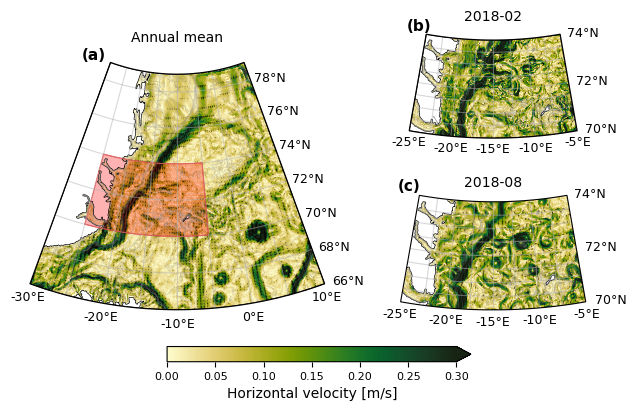

In [8]:
depth_focus = depth.sel(X=slice(-25,-5)).sel(Y=slice(70,74))
depth_notZero_m = depth_notZero.sel(X=slice(-25,-5)).sel(Y=slice(70,74))

lon = depth_focus['XC']
lat = depth_focus['YC']

norm = mcolors.Normalize(vmin=0, vmax=0.5)
hor_vel = hor_vel_r.where(depth_focus)
hor_vel_0_normalized = norm(hor_vel)
U_interp = U_interp_r.where(depth_focus)
V_interp = V_interp_r.where(depth_focus)

hor_vel_mean = hor_vel_mean_r.where(depth)
hor_vel_0_normalized_mean = norm(hor_vel_mean)
U_interp_mean = U_interp_mean_r.where(depth)
V_interp_mean = V_interp_mean_r.where(depth)

proj_l = ccrs.NorthPolarStereo(central_longitude=-10)
proj_ur_lr = ccrs.NorthPolarStereo(central_longitude=-15)

# Create a figure and axis with Cartopy using NorthPolarStereo projection
fig, ax = plt.subplot_mosaic([['l','ur',],['l','lr']],gridspec_kw={'width_ratios': [0.5, 0.4]},subplot_kw={'projection': proj_l},
    figsize=(6.2217, 4))

ax['ur'].remove()
ax['lr'].remove()

ax['ur'] = fig.add_subplot(2, 2, 2, projection=proj_ur_lr)
ax['lr'] = fig.add_subplot(2, 2, 4, projection=proj_ur_lr)


# Set the extent to focus on the desired geographical area
extent = [-25+15, -5+15, 70, 74]

pos = ['l','ur','lr']

for i in range(0,3):
        if i == 0:
             ax[pos[i]].contour(depth.XC,depth.YC,depth_notZero,[0],colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
             ax[pos[i]].contour(depth.XC,depth.YC,depth_notZero,[100,200,300,400,500,750,1000,1500,2000,3000,4000],colors='grey', linewidths=0.5,alpha=0.3, transform=ccrs.PlateCarree())
        else:
             ax[pos[i]].contour(lon,lat,depth_notZero_m,[0],colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
             ax[pos[i]].contour(lon,lat,depth_notZero_m,[100,200,300,400,500,750,1000,1500,2000,3000,4000],colors='grey', linewidths=0.5,alpha=0.3, transform=ccrs.PlateCarree())


cmap = cmo.speed

# Plot
colors = cmap(hor_vel_0_normalized)

# Focus area
focus_area_lons = np.linspace(-25, -5, 100)
focus_area_lats_bottom = np.full_like(focus_area_lons, 70)
focus_area_lats_top = np.full_like(focus_area_lons, 74)

# Combine the vertices for the focus area
focus_area_lons = np.concatenate([focus_area_lons, focus_area_lons[::-1]])
focus_area_lats = np.concatenate([focus_area_lats_bottom, focus_area_lats_top])

# Plot the focus area in PlateCarree projection
ax['l'].plot(focus_area_lons, focus_area_lats, transform=ccrs.PlateCarree(), linewidth=0.5, color='red', label='Focus area')
ax['l'].plot([-25,-25],[70,74], transform=ccrs.PlateCarree(),linewidth=0.3, color='red')
ax['l'].fill(focus_area_lons, focus_area_lats, transform=ccrs.PlateCarree(), color='red', alpha=0.3)

# assert U_interp.shape == V_interp.shape == hor_vel.shape, "Shapes of U, V, and hor_vel must match"

# ax.streamplot(X,Y,U_interp,V_interp, density=1.5, broken_streamlines=False, color=hor_vel_0_normalized, cmap=cmap, transform=ccrs.PlateCarree())
ax['l'].pcolormesh(hor_vel_mean.X,hor_vel_mean.Y, hor_vel_mean, vmin=0, vmax=0.3, cmap=cmap, zorder=0 , transform=ccrs.PlateCarree())
ax['ur'].pcolormesh(hor_vel.X,hor_vel.Y, hor_vel[1], vmin=0, vmax=0.3, cmap=cmap, zorder=0 , transform=ccrs.PlateCarree())
mesh = ax['lr'].pcolormesh(hor_vel.X,hor_vel.Y, hor_vel[2], vmin=0, vmax=0.3, cmap=cmap, zorder=0 , transform=ccrs.PlateCarree())

subsample_factor = 10  # Adjust this value to control the density, e.g., 1 for highest density

# Define the custom colormap
colors = [(1, 1, 1), (1, 1, 1), (0, 0, 0), (0, 0, 0)]  # White to white, then black to black
nodes = [0.0, 0.1, 0.1, 1.0]  # Positions of the colors

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(nodes, colors)))

q_X, q_Y = np.meshgrid(hor_vel_mean.X,hor_vel_mean.Y) 
quiver = ax['l'].quiver(q_X[::subsample_factor, ::subsample_factor], q_Y[::subsample_factor, ::subsample_factor],
          U_interp_mean.values[::subsample_factor, ::subsample_factor],
          V_interp_mean.values[::subsample_factor, ::subsample_factor],
          hor_vel_0_normalized_mean[::subsample_factor, ::subsample_factor],
          cmap=custom_cmap, scale=0.0000075, scale_units='xy', edgecolor='white', alpha=0.7, zorder=1, transform=ccrs.PlateCarree())

for i in range(1,3):
        q_X, q_Y = np.meshgrid(hor_vel.X,hor_vel.Y) 
        quiver = ax[pos[i]].quiver(q_X[::subsample_factor, ::subsample_factor], q_Y[::subsample_factor, ::subsample_factor],
                U_interp.values[i][::subsample_factor, ::subsample_factor],
                V_interp.values[i][::subsample_factor, ::subsample_factor],
                hor_vel_0_normalized[i][::subsample_factor, ::subsample_factor],
                cmap=custom_cmap, scale=0.0000075, scale_units='xy', edgecolor='white', alpha=0.7, zorder=1, transform=ccrs.PlateCarree())

cbar = fig.colorbar(mesh,shrink=0.5,ax=[ax['l'],ax['lr']],pad=0.05,orientation="horizontal",extend='max')
cbar.set_label('Horizontal velocity [m/s]')

ax['l'].set_title('Annual mean')
for i in range(1,3):
      ax[pos[i]].set_title(f'{str(hor_vel.time.values[i])[:7]}')
#ax2.set_title('b) Temperature',fontsize=15,fontweight='bold')

# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)

patch = PathPatch(path, transform=ax['ur'].transData, edgecolor='black', facecolor='none')
ax['ur'].add_patch(patch)

patch = PathPatch(path, transform=ax['ur'].transData, edgecolor='black', facecolor='none')
ax['lr'].add_patch(patch)

# Set the boundary using the transformed path
ax['ur'].set_boundary(patch.get_path(), transform=ax['ur'].transData)
ax['lr'].set_boundary(patch.get_path(), transform=ax['lr'].transData)

# Add gridlines without labels
ax['ur'].gridlines(draw_labels=False,alpha=0.5)
ax['lr'].gridlines(draw_labels=False,alpha=0.5)

# Manually add the labels for the bottom and right sides
xticks = np.arange(extent[0]-15, extent[1]-15 + 1, 5)  # Adjust the range and step as needed
yticks = np.arange(extent[2], extent[3] + 1, 2)  # Adjust the range and step as needed

# Add bottom labels
for xtick in xticks:
    ax['ur'].text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
            fontsize=9, ha='center', va='top')
    ax['lr'].text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
            fontsize=9, ha='center', va='top')

# Add right labels
for ytick in yticks:
    ax['ur'].text(extent[1] + 1-15, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
            fontsize=9, ha='left', va='center')
    ax['lr'].text(extent[1] + 1-15, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
            fontsize=9, ha='left', va='center')

# Mean data structure
extent = [-30+10, 10+10, 66, 79]

# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=ax['l'].transData, edgecolor='black', facecolor='none')
ax['l'].add_patch(patch)


# Set the boundary using the transformed path
ax['l'].set_boundary(patch.get_path(), transform=ax['l'].transData)

# Add gridlines without labels
ax['l'].gridlines(draw_labels=False,alpha=0.5)

# Manually add the labels for the bottom and right sides
xticks = np.arange(extent[0]-10, extent[1]-10 + 1, 10)  # Adjust the range and step as needed
yticks = np.arange(extent[2], extent[3] + 1, 2)  # Adjust the range and step as needed

# Add bottom labels
for xtick in xticks:
    ax['l'].text(xtick, extent[2]-0.4, f'{xtick}°E', transform=ccrs.PlateCarree(),
            fontsize=9, ha='center', va='top')

# Add right labels
for ytick in yticks:
    ax['l'].text(extent[1] + 1-10, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
            fontsize=9, ha='left', va='center')

letter = ['(a)','(b)','(c)']
coords = [[-30-8,78.5],[-25-3,74],[-25-3,74]]
for i in range(0,3):
     ax[pos[i]].annotate(text=letter[i],xy=coords[i],fontweight='bold', transform=ccrs.PlateCarree())


fig.set_layout_engine('constrained')
fig.get_layout_engine().set(w_pad=0,h_pad=0.05,hspace=0.0, wspace=0)

fig.savefig(r'/nird/home/ekv036/MSc/Fig/MeanCurrent_multi',dpi=300, facecolor='w', edgecolor='w',
          orientation='landscape', format=None,
          transparent=False, bbox_inches=None,pad_inches=0.25)

## Salinity

In [9]:
SA = df.S
SA_mean = SA.sel(Z=-11.5).mean(dim='time')
SA = SA.sel(Z=-11.5).sel(time=['2017-09-01T00:00:00.000000000','2018-02-01T00:00:00.000000000','2018-08-01T00:00:00.000000000']).sel(X=slice(-25,-5)).sel(Y=slice(70,74))

In [10]:
SA

<xarray.DataArray 'S' (time: 3, Y: 198, X: 422)>
[250668 values with dtype=float64]
Coordinates:
    Z        float64 -11.5
  * X        (X) float64 -24.98 -24.91 -24.85 -24.79 ... -5.112 -5.066 -5.021
  * Y        (Y) float64 70.01 70.03 70.04 70.06 ... 73.9 73.93 73.95 73.98
    XC       (Y, X) float64 ...
    YC       (Y, X) float64 ...
  * time     (time) datetime64[ns] 2017-09-01 2018-02-01 2018-08-01
Attributes:
    long_name:      salinity
    standard_name:  sea_water_salinity
    units:          g kg-1
    _coordinates:   XC YC RC iter

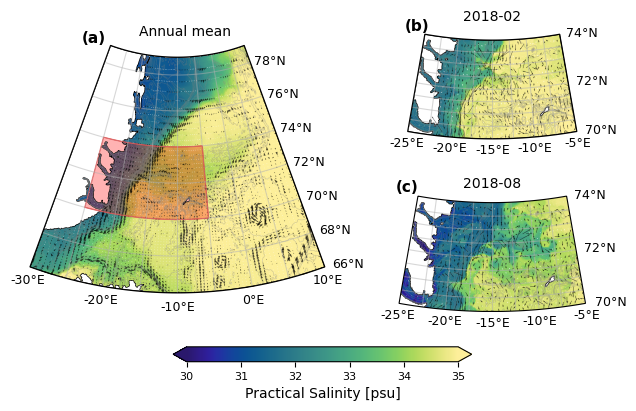

In [11]:
depth_focus = depth.sel(X=slice(-25,-5)).sel(Y=slice(70,74))
depth_notZero_m = depth_notZero.sel(X=slice(-25,-5)).sel(Y=slice(70,74))

lon = depth_focus['XC']
lat = depth_focus['YC']

norm = mcolors.Normalize(vmin=0, vmax=0.5)
hor_vel = hor_vel_r.where(depth_focus)
hor_vel_0_normalized = norm(hor_vel)
U_interp = U_interp_r.where(depth_focus)
V_interp = V_interp_r.where(depth_focus)

hor_vel_mean = hor_vel_mean_r.where(depth)
hor_vel_0_normalized_mean = norm(hor_vel_mean)
U_interp_mean = U_interp_mean_r.where(depth)
V_interp_mean = V_interp_mean_r.where(depth)

proj_l = ccrs.NorthPolarStereo(central_longitude=-10)
proj_ur_lr = ccrs.NorthPolarStereo(central_longitude=-15)

# Create a figure and axis with Cartopy using NorthPolarStereo projection
fig, ax = plt.subplot_mosaic([['l','ur',],['l','lr']],gridspec_kw={'width_ratios': [0.5, 0.4]},subplot_kw={'projection': proj_l},
    figsize=(6.2217, 4))

ax['ur'].remove()
ax['lr'].remove()

ax['ur'] = fig.add_subplot(2, 2, 2, projection=proj_ur_lr)
ax['lr'] = fig.add_subplot(2, 2, 4, projection=proj_ur_lr)


# Set the extent to focus on the desired geographical area
extent = [-25+15, -5+15, 70, 74]

pos = ['l','ur','lr']

for i in range(0,3):
        if i == 0:
             ax[pos[i]].contour(depth.XC,depth.YC,depth_notZero,[0],colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
             ax[pos[i]].contour(depth.XC,depth.YC,depth_notZero,[100,200,300,400,500,750,1000,1500,2000,3000,4000],colors='grey', linewidths=0.5,alpha=0.3, transform=ccrs.PlateCarree())
        else:
             ax[pos[i]].contour(lon,lat,depth_notZero_m,[0],colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
             ax[pos[i]].contour(lon,lat,depth_notZero_m,[100,200,300,400,500,750,1000,1500,2000,3000,4000],colors='grey', linewidths=0.5,alpha=0.3, transform=ccrs.PlateCarree())


cmap = cmo.haline

# Plot
colors = cmap(hor_vel_0_normalized)

# Focus area
focus_area_lons = np.linspace(-25, -5, 100)
focus_area_lats_bottom = np.full_like(focus_area_lons, 70)
focus_area_lats_top = np.full_like(focus_area_lons, 74)

# Combine the vertices for the focus area
focus_area_lons = np.concatenate([focus_area_lons, focus_area_lons[::-1]])
focus_area_lats = np.concatenate([focus_area_lats_bottom, focus_area_lats_top])

# Plot the focus area in PlateCarree projection
ax['l'].plot(focus_area_lons, focus_area_lats, transform=ccrs.PlateCarree(), linewidth=0.5, color='red', label='Focus area')
ax['l'].plot([-25,-25],[70,74], transform=ccrs.PlateCarree(),linewidth=0.3, color='red')
ax['l'].fill(focus_area_lons, focus_area_lats, transform=ccrs.PlateCarree(), color='red', alpha=0.3)

# Pcolormesh
mesh = ax['l'].pcolormesh(SA_mean.X,SA_mean.Y,SA_mean, cmap=cmap, vmin=30, vmax=35, zorder=0 , transform=ccrs.PlateCarree())
ax['ur'].pcolormesh(SA.X,SA.Y,SA[1], cmap=cmap, vmin=30, vmax=35, zorder=0 , transform=ccrs.PlateCarree())
ax['lr'].pcolormesh(SA.X,SA.Y,SA[2], cmap=cmap, vmin=30, vmax=35, zorder=0 , transform=ccrs.PlateCarree())

subsample_factor = 10  # Adjust this value to control the density, e.g., 1 for highest density

# Define the custom colormap
colors = [(1, 1, 1), (1, 1, 1), (0, 0, 0), (0, 0, 0)]  # White to white, then black to black
nodes = [0.0, 0.1, 0.1, 1.0]  # Positions of the colors

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(nodes, colors)))

q_X, q_Y = np.meshgrid(hor_vel_mean.X,hor_vel_mean.Y) 
quiver = ax['l'].quiver(q_X[::subsample_factor, ::subsample_factor], q_Y[::subsample_factor, ::subsample_factor],
          U_interp_mean.values[::subsample_factor, ::subsample_factor],
          V_interp_mean.values[::subsample_factor, ::subsample_factor],
          hor_vel_0_normalized_mean[::subsample_factor, ::subsample_factor],
          cmap=custom_cmap, scale=0.0000075, scale_units='xy', edgecolor='white', alpha=0.7, zorder=1, transform=ccrs.PlateCarree())

for i in range(1,3):
        q_X, q_Y = np.meshgrid(hor_vel.X,hor_vel.Y) 
        quiver = ax[pos[i]].quiver(q_X[::subsample_factor, ::subsample_factor], q_Y[::subsample_factor, ::subsample_factor],
                U_interp.values[i][::subsample_factor, ::subsample_factor],
                V_interp.values[i][::subsample_factor, ::subsample_factor],
                hor_vel_0_normalized[i][::subsample_factor, ::subsample_factor],
                cmap=custom_cmap, scale=0.0000075, scale_units='xy', edgecolor='white', alpha=0.7, zorder=1, transform=ccrs.PlateCarree())

cbar = fig.colorbar(mesh,shrink=0.5,ax=[ax['l'],ax['lr']],pad=0.05,orientation="horizontal",extend='both')
cbar.set_label('Practical Salinity [psu]')

ax['l'].set_title('Annual mean')
for i in range(1,3):
      ax[pos[i]].set_title(f'{str(hor_vel.time.values[i])[:7]}')
#ax2.set_title('b) Temperature',fontsize=15,fontweight='bold')

# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)

patch = PathPatch(path, transform=ax['ur'].transData, edgecolor='black', facecolor='none')
ax['ur'].add_patch(patch)

patch = PathPatch(path, transform=ax['ur'].transData, edgecolor='black', facecolor='none')
ax['lr'].add_patch(patch)

# Set the boundary using the transformed path
ax['ur'].set_boundary(patch.get_path(), transform=ax['ur'].transData)
ax['lr'].set_boundary(patch.get_path(), transform=ax['lr'].transData)

# Add gridlines without labels
ax['ur'].gridlines(draw_labels=False,alpha=0.5)
ax['lr'].gridlines(draw_labels=False,alpha=0.5)

# Manually add the labels for the bottom and right sides
xticks = np.arange(extent[0]-15, extent[1]-15 + 1, 5)  # Adjust the range and step as needed
yticks = np.arange(extent[2], extent[3] + 1, 2)  # Adjust the range and step as needed

# Add bottom labels
for xtick in xticks:
    ax['ur'].text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
            fontsize=9, ha='center', va='top')
    ax['lr'].text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
            fontsize=9, ha='center', va='top')

# Add right labels
for ytick in yticks:
    ax['ur'].text(extent[1] + 1-15, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
            fontsize=9, ha='left', va='center')
    ax['lr'].text(extent[1] + 1-15, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
            fontsize=9, ha='left', va='center')

# Mean data structure
extent = [-30+10, 10+10, 66, 79]

# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=ax['l'].transData, edgecolor='black', facecolor='none')
ax['l'].add_patch(patch)


# Set the boundary using the transformed path
ax['l'].set_boundary(patch.get_path(), transform=ax['l'].transData)

# Add gridlines without labels
ax['l'].gridlines(draw_labels=False,alpha=0.5)

# Manually add the labels for the bottom and right sides
xticks = np.arange(extent[0]-10, extent[1]-10 + 1, 10)  # Adjust the range and step as needed
yticks = np.arange(extent[2], extent[3] + 1, 2)  # Adjust the range and step as needed

# Add bottom labels
for xtick in xticks:
    ax['l'].text(xtick, extent[2]-0.4, f'{xtick}°E', transform=ccrs.PlateCarree(),
            fontsize=9, ha='center', va='top')

# Add right labels
for ytick in yticks:
    ax['l'].text(extent[1] + 1-10, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
            fontsize=9, ha='left', va='center')

letter = ['(a)','(b)','(c)']
coords = [[-30-8,78.5],[-25-3,74],[-25-3,74]]
for i in range(0,3):
     ax[pos[i]].annotate(text=letter[i],xy=coords[i],fontweight='bold', transform=ccrs.PlateCarree())


fig.set_layout_engine('constrained')
fig.get_layout_engine().set(w_pad=0,h_pad=0.05,hspace=0.0, wspace=0)

fig.savefig(r'/nird/home/ekv036/MSc/Fig/MeanCurrentSalinity_multi',dpi=300, facecolor='w', edgecolor='w',
          orientation='landscape', format=None,
          transparent=False, bbox_inches=None,pad_inches=0.25)

In [12]:
df

<xarray.Dataset>
Dimensions:    (Z: 216, Zp1: 217, Zu: 216, Zl: 216, X: 765, Y: 628, Xp1: 766,
                Yp1: 629, time: 12, time_midp: 11)
Coordinates: (12/18)
  * Z          (Z) float64 -1.0 -3.5 -7.0 ... -3.904e+03 -3.922e+03 -3.942e+03
  * Zp1        (Zp1) float64 0.0 -2.0 -5.0 ... -3.913e+03 -3.932e+03 -3.951e+03
  * Zu         (Zu) float64 -2.0 -5.0 -9.0 ... -3.913e+03 -3.932e+03 -3.951e+03
  * Zl         (Zl) float64 0.0 -2.0 -5.0 ... -3.894e+03 -3.913e+03 -3.932e+03
  * X          (X) float64 -29.92 -29.84 -29.76 -29.67 ... 11.72 11.82 11.92
  * Y          (Y) float64 65.01 65.03 65.04 65.06 ... 78.67 78.75 78.83 78.92
    ...         ...
  * time       (time) datetime64[ns] 2017-09-01 2017-10-01 ... 2018-08-01
    YU         (Y, Xp1) float64 ...
    XU         (Y, Xp1) float64 ...
    YV         (Yp1, X) float64 ...
    XV         (Yp1, X) float64 ...
  * time_midp  (time_midp) datetime64[ns] 2017-09-16 ... 2018-07-16T12:00:00
Data variables:
    U          (time, Z, Y, Xp1) float64 ...
    V          (time, Z, Yp1, X) float64 ...
    Temp       (time, Z, Y, X) float64 ...
    S          (time, Z, Y, X) float64 ...
    Eta        (time, Y, X) float64 ...
    MXLDEPTH   (time, Y, X) float64 ...
    SIarea     (time, Y, X) float64 ...
    SIheff     (time, Y, X) float64 ...
Attributes: (12/24)
    MITgcm_version:          checkpoint67l
    build_user:              malmans2@jhu.edu
    build_host:              compute0673
    build_date:              Fri Nov  8 01:36:45 EST 2019
    MITgcm_URL:              http://mitgcm.org
    MITgcm_tag_id:           
    ...                      ...
    OceanSpy_parameters:     {'rSphere': 6371.0, 'eq_state': 'mdjwf', 'rho0':...
    OceanSpy_name:           IGPyearlong
    OceanSpy_description:    High-resolution numerical simulation carried out...
    OceanSpy_projection:     Mercator(**{})
    OceanSpy_grid_coords:    {'Y': {'Y': None, 'Yp1': 0.5}, 'X': {'X': None, ...
    OceanSpy_grid_periodic:  []

# Temperature

In [13]:
TP =df.Temp
TP_mean = TP.sel(Z=-11.5).mean(dim='time')
TP = TP.sel(Z=-11.5).sel(time=['2017-09-01T00:00:00.000000000','2018-02-01T00:00:00.000000000','2018-08-01T00:00:00.000000000']).sel(X=slice(-25,-5)).sel(Y=slice(70,74))

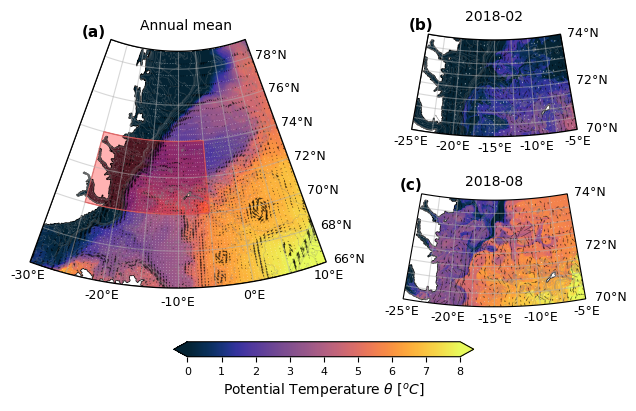

In [14]:
depth_focus = depth.sel(X=slice(-25,-5)).sel(Y=slice(70,74))
depth_notZero_m = depth_notZero.sel(X=slice(-25,-5)).sel(Y=slice(70,74))

lon = depth_focus['XC']
lat = depth_focus['YC']

norm = mcolors.Normalize(vmin=0, vmax=0.5)
hor_vel = hor_vel_r.where(depth_focus)
hor_vel_0_normalized = norm(hor_vel)
U_interp = U_interp_r.where(depth_focus)
V_interp = V_interp_r.where(depth_focus)

hor_vel_mean = hor_vel_mean_r.where(depth)
hor_vel_0_normalized_mean = norm(hor_vel_mean)
U_interp_mean = U_interp_mean_r.where(depth)
V_interp_mean = V_interp_mean_r.where(depth)

proj_l = ccrs.NorthPolarStereo(central_longitude=-10)
proj_ur_lr = ccrs.NorthPolarStereo(central_longitude=-15)

# Create a figure and axis with Cartopy using NorthPolarStereo projection
fig, ax = plt.subplot_mosaic([['l','ur',],['l','lr']],gridspec_kw={'width_ratios': [0.5, 0.4]},subplot_kw={'projection': proj_l},
    figsize=(6.2217, 4))

ax['ur'].remove()
ax['lr'].remove()

ax['ur'] = fig.add_subplot(2, 2, 2, projection=proj_ur_lr)
ax['lr'] = fig.add_subplot(2, 2, 4, projection=proj_ur_lr)


# Set the extent to focus on the desired geographical area
extent = [-25+15, -5+15, 70, 74]

pos = ['l','ur','lr']

for i in range(0,3):
        if i == 0:
             ax[pos[i]].contour(depth.XC,depth.YC,depth_notZero,[0],colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
             ax[pos[i]].contour(depth.XC,depth.YC,depth_notZero,[100,200,300,400,500,750,1000,1500,2000,3000,4000],colors='grey', linewidths=0.5,alpha=0.3, transform=ccrs.PlateCarree())
        else:
             ax[pos[i]].contour(lon,lat,depth_notZero_m,[0],colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
             ax[pos[i]].contour(lon,lat,depth_notZero_m,[100,200,300,400,500,750,1000,1500,2000,3000,4000],colors='grey', linewidths=0.5,alpha=0.3, transform=ccrs.PlateCarree())


cmap = cmo.thermal

# Plot
colors = cmap(hor_vel_0_normalized)

# Focus area
focus_area_lons = np.linspace(-25, -5, 100)
focus_area_lats_bottom = np.full_like(focus_area_lons, 70)
focus_area_lats_top = np.full_like(focus_area_lons, 74)

# Combine the vertices for the focus area
focus_area_lons = np.concatenate([focus_area_lons, focus_area_lons[::-1]])
focus_area_lats = np.concatenate([focus_area_lats_bottom, focus_area_lats_top])

# Plot the focus area in PlateCarree projection
ax['l'].plot(focus_area_lons, focus_area_lats, transform=ccrs.PlateCarree(), linewidth=0.5, color='red', label='Focus area')
ax['l'].plot([-25,-25],[70,74], transform=ccrs.PlateCarree(),linewidth=0.3, color='red')
ax['l'].fill(focus_area_lons, focus_area_lats, transform=ccrs.PlateCarree(), color='red', alpha=0.3)

# Pcolormesh
mesh = ax['l'].pcolormesh(TP_mean.X,TP_mean.Y,TP_mean, cmap=cmap, vmin=0, vmax=8, zorder=0 , transform=ccrs.PlateCarree())
ax['ur'].pcolormesh(TP.X,TP.Y,TP[1], cmap=cmap, vmin=0, vmax=8, zorder=0 , transform=ccrs.PlateCarree())
ax['lr'].pcolormesh(TP.X,TP.Y,TP[2], cmap=cmap, vmin=0, vmax=8, zorder=0 , transform=ccrs.PlateCarree())

subsample_factor = 10  # Adjust this value to control the density, e.g., 1 for highest density

# Define the custom colormap
colors = [(1, 1, 1), (1, 1, 1), (0, 0, 0), (0, 0, 0)]  # White to white, then black to black
nodes = [0.0, 0.1, 0.1, 1.0]  # Positions of the colors

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(nodes, colors)))

q_X, q_Y = np.meshgrid(hor_vel_mean.X,hor_vel_mean.Y) 
quiver = ax['l'].quiver(q_X[::subsample_factor, ::subsample_factor], q_Y[::subsample_factor, ::subsample_factor],
          U_interp_mean.values[::subsample_factor, ::subsample_factor],
          V_interp_mean.values[::subsample_factor, ::subsample_factor],
          hor_vel_0_normalized_mean[::subsample_factor, ::subsample_factor],
          cmap=custom_cmap, scale=0.0000075, scale_units='xy', edgecolor='white', alpha=0.7, zorder=1, transform=ccrs.PlateCarree())

for i in range(1,3):
        q_X, q_Y = np.meshgrid(hor_vel.X,hor_vel.Y) 
        quiver = ax[pos[i]].quiver(q_X[::subsample_factor, ::subsample_factor], q_Y[::subsample_factor, ::subsample_factor],
                U_interp.values[i][::subsample_factor, ::subsample_factor],
                V_interp.values[i][::subsample_factor, ::subsample_factor],
                hor_vel_0_normalized[i][::subsample_factor, ::subsample_factor],
                cmap=custom_cmap, scale=0.0000075, scale_units='xy', edgecolor='white', alpha=0.7, zorder=1, transform=ccrs.PlateCarree())

cbar = fig.colorbar(mesh,shrink=0.5,ax=[ax['l'],ax['lr']],pad=0.05,orientation="horizontal",extend='both')
cbar.set_label(r'Potential Temperature $\theta$ [$^oC$]')

ax['l'].set_title('Annual mean')
for i in range(1,3):
      ax[pos[i]].set_title(f'{str(hor_vel.time.values[i])[:7]}')
#ax2.set_title('b) Temperature',fontsize=15,fontweight='bold')

# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)

patch = PathPatch(path, transform=ax['ur'].transData, edgecolor='black', facecolor='none')
ax['ur'].add_patch(patch)

patch = PathPatch(path, transform=ax['ur'].transData, edgecolor='black', facecolor='none')
ax['lr'].add_patch(patch)

# Set the boundary using the transformed path
ax['ur'].set_boundary(patch.get_path(), transform=ax['ur'].transData)
ax['lr'].set_boundary(patch.get_path(), transform=ax['lr'].transData)

# Add gridlines without labels
ax['ur'].gridlines(draw_labels=False,alpha=0.5)
ax['lr'].gridlines(draw_labels=False,alpha=0.5)

# Manually add the labels for the bottom and right sides
xticks = np.arange(extent[0]-15, extent[1]-15 + 1, 5)  # Adjust the range and step as needed
yticks = np.arange(extent[2], extent[3] + 1, 2)  # Adjust the range and step as needed

# Add bottom labels
for xtick in xticks:
    ax['ur'].text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
            fontsize=9, ha='center', va='top')
    ax['lr'].text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
            fontsize=9, ha='center', va='top')

# Add right labels
for ytick in yticks:
    ax['ur'].text(extent[1] + 1-15, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
            fontsize=9, ha='left', va='center')
    ax['lr'].text(extent[1] + 1-15, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
            fontsize=9, ha='left', va='center')

# Mean data structure
extent = [-30+10, 10+10, 66, 79]

# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=ax['l'].transData, edgecolor='black', facecolor='none')
ax['l'].add_patch(patch)


# Set the boundary using the transformed path
ax['l'].set_boundary(patch.get_path(), transform=ax['l'].transData)

# Add gridlines without labels
ax['l'].gridlines(draw_labels=False,alpha=0.5)

# Manually add the labels for the bottom and right sides
xticks = np.arange(extent[0]-10, extent[1]-10 + 1, 10)  # Adjust the range and step as needed
yticks = np.arange(extent[2], extent[3] + 1, 2)  # Adjust the range and step as needed

# Add bottom labels
for xtick in xticks:
    ax['l'].text(xtick, extent[2]-0.4, f'{xtick}°E', transform=ccrs.PlateCarree(),
            fontsize=9, ha='center', va='top')

# Add right labels
for ytick in yticks:
    ax['l'].text(extent[1] + 1-10, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
            fontsize=9, ha='left', va='center')

letter = ['(a)','(b)','(c)']
coords = [[-30-8,78.5],[-25-3,74],[-25-3,74]]
for i in range(0,3):
     ax[pos[i]].annotate(text=letter[i],xy=coords[i],fontweight='bold', transform=ccrs.PlateCarree())


fig.set_layout_engine('constrained')
fig.get_layout_engine().set(w_pad=0,h_pad=0.05,hspace=0.0, wspace=0)

fig.savefig(r'/nird/home/ekv036/MSc/Fig/MeanCurrentTemperature_multi',dpi=300, facecolor='w', edgecolor='w',
          orientation='landscape', format=None,
          transparent=False, bbox_inches=None,pad_inches=0.25)

# Mixed layer depth

In [15]:
MLD = df.MXLDEPTH
MLD_mean = MLD.mean(dim='time').where(depth)
MLD = MLD.sel(time=['2017-09-01T00:00:00.000000000','2018-02-01T00:00:00.000000000','2018-08-01T00:00:00.000000000']).sel(X=slice(-25,-5)).sel(Y=slice(70,74)).where(depth)

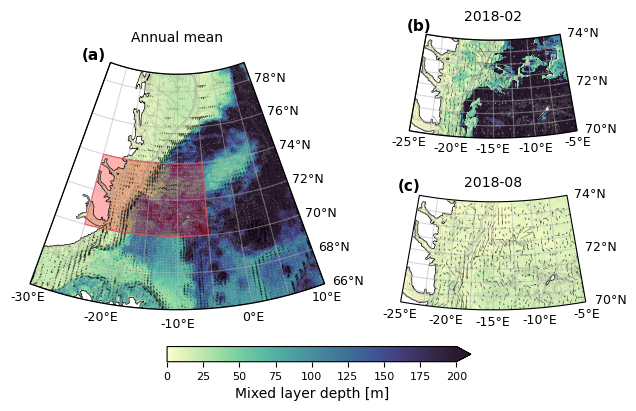

In [16]:
depth_focus = depth.sel(X=slice(-25,-5)).sel(Y=slice(70,74))
depth_notZero_m = depth_notZero.sel(X=slice(-25,-5)).sel(Y=slice(70,74))

lon = depth_focus['XC']
lat = depth_focus['YC']

norm = mcolors.Normalize(vmin=0, vmax=0.5)
hor_vel = hor_vel_r.where(depth_focus)
hor_vel_0_normalized = norm(hor_vel)
U_interp = U_interp_r.where(depth_focus)
V_interp = V_interp_r.where(depth_focus)

hor_vel_mean = hor_vel_mean_r.where(depth)
hor_vel_0_normalized_mean = norm(hor_vel_mean)
U_interp_mean = U_interp_mean_r.where(depth)
V_interp_mean = V_interp_mean_r.where(depth)

proj_l = ccrs.NorthPolarStereo(central_longitude=-10)
proj_ur_lr = ccrs.NorthPolarStereo(central_longitude=-15)

# Create a figure and axis with Cartopy using NorthPolarStereo projection
fig, ax = plt.subplot_mosaic([['l','ur',],['l','lr']],gridspec_kw={'width_ratios': [0.5, 0.4]},subplot_kw={'projection': proj_l},
    figsize=(6.2217, 4))

ax['ur'].remove()
ax['lr'].remove()

ax['ur'] = fig.add_subplot(2, 2, 2, projection=proj_ur_lr)
ax['lr'] = fig.add_subplot(2, 2, 4, projection=proj_ur_lr)


# Set the extent to focus on the desired geographical area
extent = [-25+15, -5+15, 70, 74]

pos = ['l','ur','lr']

for i in range(0,3):
        if i == 0:
             ax[pos[i]].contour(depth.XC,depth.YC,depth_notZero,[0],colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
             ax[pos[i]].contour(depth.XC,depth.YC,depth_notZero,[100,200,300,400,500,750,1000,1500,2000,3000,4000],colors='grey', linewidths=0.5,alpha=0.3, transform=ccrs.PlateCarree())
        else:
             ax[pos[i]].contour(lon,lat,depth_notZero_m,[0],colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
             ax[pos[i]].contour(lon,lat,depth_notZero_m,[100,200,300,400,500,750,1000,1500,2000,3000,4000],colors='grey', linewidths=0.5,alpha=0.3, transform=ccrs.PlateCarree())


cmap = cmo.deep

# Plot
colors = cmap(hor_vel_0_normalized)

# Focus area
focus_area_lons = np.linspace(-25, -5, 100)
focus_area_lats_bottom = np.full_like(focus_area_lons, 70)
focus_area_lats_top = np.full_like(focus_area_lons, 74)

# Combine the vertices for the focus area
focus_area_lons = np.concatenate([focus_area_lons, focus_area_lons[::-1]])
focus_area_lats = np.concatenate([focus_area_lats_bottom, focus_area_lats_top])

# Plot the focus area in PlateCarree projection
ax['l'].plot(focus_area_lons, focus_area_lats, transform=ccrs.PlateCarree(), linewidth=0.5, color='red', label='Focus area')
ax['l'].plot([-25,-25],[70,74], transform=ccrs.PlateCarree(),linewidth=0.3, color='red')
ax['l'].fill(focus_area_lons, focus_area_lats, transform=ccrs.PlateCarree(), color='red', alpha=0.3)

# Pcolormesh
mesh = ax['l'].pcolormesh(MLD_mean.X,MLD_mean.Y,MLD_mean, cmap=cmap, vmin=0, vmax=200, zorder=0 , transform=ccrs.PlateCarree())

ax['ur'].pcolormesh(MLD.X,MLD.Y,MLD[1], cmap=cmap, vmin=0, vmax=200, zorder=0 , transform=ccrs.PlateCarree())
ax['lr'].pcolormesh(MLD.X,MLD.Y,MLD[2], cmap=cmap, vmin=0, vmax=200, zorder=0 , transform=ccrs.PlateCarree())

subsample_factor = 10  # Adjust this value to control the density, e.g., 1 for highest density

# Define the custom colormap
colors = [(1, 1, 1), (1, 1, 1), (0, 0, 0), (0, 0, 0)]  # White to white, then black to black
nodes = [0.0, 0.1, 0.1, 1.0]  # Positions of the colors

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(nodes, colors)))

q_X, q_Y = np.meshgrid(hor_vel_mean.X,hor_vel_mean.Y) 
quiver = ax['l'].quiver(q_X[::subsample_factor, ::subsample_factor], q_Y[::subsample_factor, ::subsample_factor],
          U_interp_mean.values[::subsample_factor, ::subsample_factor],
          V_interp_mean.values[::subsample_factor, ::subsample_factor],
          hor_vel_0_normalized_mean[::subsample_factor, ::subsample_factor],
          cmap=custom_cmap, scale=0.0000075, scale_units='xy', edgecolor='white', alpha=0.7, zorder=1, transform=ccrs.PlateCarree())

for i in range(1,3):
        q_X, q_Y = np.meshgrid(hor_vel.X,hor_vel.Y) 
        quiver = ax[pos[i]].quiver(q_X[::subsample_factor, ::subsample_factor], q_Y[::subsample_factor, ::subsample_factor],
                U_interp.values[i][::subsample_factor, ::subsample_factor],
                V_interp.values[i][::subsample_factor, ::subsample_factor],
                hor_vel_0_normalized[i][::subsample_factor, ::subsample_factor],
                cmap=custom_cmap, scale=0.0000075, scale_units='xy', edgecolor='white', alpha=0.7, zorder=1, transform=ccrs.PlateCarree())

cbar = fig.colorbar(mesh,shrink=0.5,ax=[ax['l'],ax['lr']],pad=0.05,orientation="horizontal",extend='max')
cbar.set_label('Mixed layer depth [m]')

ax['l'].set_title('Annual mean')
for i in range(1,3):
      ax[pos[i]].set_title(f'{str(hor_vel.time.values[i])[:7]}')
#ax2.set_title('b) Temperature',fontsize=15,fontweight='bold')

# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)

patch = PathPatch(path, transform=ax['ur'].transData, edgecolor='black', facecolor='none')
ax['ur'].add_patch(patch)

patch = PathPatch(path, transform=ax['ur'].transData, edgecolor='black', facecolor='none')
ax['lr'].add_patch(patch)

# Set the boundary using the transformed path
ax['ur'].set_boundary(patch.get_path(), transform=ax['ur'].transData)
ax['lr'].set_boundary(patch.get_path(), transform=ax['lr'].transData)

# Add gridlines without labels
ax['ur'].gridlines(draw_labels=False,alpha=0.5)
ax['lr'].gridlines(draw_labels=False,alpha=0.5)

# Manually add the labels for the bottom and right sides
xticks = np.arange(extent[0]-15, extent[1]-15 + 1, 5)  # Adjust the range and step as needed
yticks = np.arange(extent[2], extent[3] + 1, 2)  # Adjust the range and step as needed

# Add bottom labels
for xtick in xticks:
    ax['ur'].text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
            fontsize=9, ha='center', va='top')
    ax['lr'].text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
            fontsize=9, ha='center', va='top')

# Add right labels
for ytick in yticks:
    ax['ur'].text(extent[1] + 1-15, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
            fontsize=9, ha='left', va='center')
    ax['lr'].text(extent[1] + 1-15, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
            fontsize=9, ha='left', va='center')

# Mean data structure
extent = [-30+10, 10+10, 66, 79]

# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=ax['l'].transData, edgecolor='black', facecolor='none')
ax['l'].add_patch(patch)


# Set the boundary using the transformed path
ax['l'].set_boundary(patch.get_path(), transform=ax['l'].transData)

# Add gridlines without labels
ax['l'].gridlines(draw_labels=False,alpha=0.5)

# Manually add the labels for the bottom and right sides
xticks = np.arange(extent[0]-10, extent[1]-10 + 1, 10)  # Adjust the range and step as needed
yticks = np.arange(extent[2], extent[3] + 1, 2)  # Adjust the range and step as needed

# Add bottom labels
for xtick in xticks:
    ax['l'].text(xtick, extent[2]-0.4, f'{xtick}°E', transform=ccrs.PlateCarree(),
            fontsize=9, ha='center', va='top')

# Add right labels
for ytick in yticks:
    ax['l'].text(extent[1] + 1-10, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
            fontsize=9, ha='left', va='center')

letter = ['(a)','(b)','(c)']
coords = [[-30-8,78.5],[-25-3,74],[-25-3,74]]
for i in range(0,3):
     ax[pos[i]].annotate(text=letter[i],xy=coords[i],fontweight='bold', transform=ccrs.PlateCarree())


fig.set_layout_engine('constrained')
fig.get_layout_engine().set(w_pad=0,h_pad=0.05,hspace=0.0, wspace=0)

fig.savefig(r'/nird/home/ekv036/MSc/Fig/MeanCurrentMLD_multi',dpi=300, facecolor='w', edgecolor='w',
          orientation='landscape', format=None,
          transparent=False, bbox_inches=None,pad_inches=0.25)

In [17]:
od = ospy.OceanDataset(df)
od_cut = od.subsample.cutout(varList=['S'])

Cutting out the oceandataset.


In [18]:
od_cut.dataset

<xarray.Dataset>
Dimensions:    (Z: 216, Zp1: 217, Zu: 216, Zl: 216, X: 765, Y: 628, Xp1: 766,
                Yp1: 629, time: 12, time_midp: 11)
Coordinates: (12/18)
  * Z          (Z) float64 -1.0 -3.5 -7.0 ... -3.904e+03 -3.922e+03 -3.942e+03
  * Zp1        (Zp1) float64 0.0 -2.0 -5.0 ... -3.913e+03 -3.932e+03 -3.951e+03
  * Zu         (Zu) float64 -2.0 -5.0 -9.0 ... -3.913e+03 -3.932e+03 -3.951e+03
  * Zl         (Zl) float64 0.0 -2.0 -5.0 ... -3.894e+03 -3.913e+03 -3.932e+03
  * X          (X) float64 -29.92 -29.84 -29.76 -29.67 ... 11.72 11.82 11.92
  * Y          (Y) float64 65.01 65.03 65.04 65.06 ... 78.67 78.75 78.83 78.92
    ...         ...
  * time       (time) datetime64[ns] 2017-09-01 2017-10-01 ... 2018-08-01
    YU         (Y, Xp1) float64 ...
    XU         (Y, Xp1) float64 ...
    YV         (Yp1, X) float64 ...
    XV         (Yp1, X) float64 ...
  * time_midp  (time_midp) datetime64[ns] 2017-09-16 ... 2018-07-16T12:00:00
Data variables:
    S          (time, Z, Y, X) float64 ...
Attributes: (12/24)
    MITgcm_version:          checkpoint67l
    build_user:              malmans2@jhu.edu
    build_host:              compute0673
    build_date:              Fri Nov  8 01:36:45 EST 2019
    MITgcm_URL:              http://mitgcm.org
    MITgcm_tag_id:           
    ...                      ...
    OceanSpy_parameters:     {'rSphere': 6371.0, 'eq_state': 'mdjwf', 'rho0':...
    OceanSpy_name:           IGPyearlong
    OceanSpy_description:    High-resolution numerical simulation carried out...
    OceanSpy_projection:     Mercator(**{})
    OceanSpy_grid_coords:    {'Y': {'Y': None, 'Yp1': 0.5}, 'X': {'X': None, ...
    OceanSpy_grid_periodic:  []

In [19]:
ref_salinity = []

df_weight = od_cut.dataset
df_weight = df_weight.sel(X=slice(-30,0)).sel(Y=slice(66,76)).sel(Z=slice(-1000,0))
# weights = ospy.OceanDataset(weights)
# weights = weights.subsample.cutout(XRange=[-30,0],YRange=[66,76],varList=['rA', 'rAw', 'rAs', 'rAz','HFacC', 'HFacW', 'HFacS','drC', 'drF'])
# weights = weights.dataset
# display(weights)

for times in df_weight.time.values:
    print(times)
    df_weight = od_cut.dataset

    df_weight['drC'] = weights['drC']
    df_weight['drF'] = weights['drF']
    df_weight['rA'] = weights['rA']
    df_weight['rAw'] = weights['rAw']
    df_weight['rAs'] = weights['rAs']
    df_weight['rAz'] = weights['rAz']
    df_weight['HFacC'] = weights['HFacC']
    df_weight['HFacW'] = weights['HFacW']
    df_weight['HFacS'] = weights['HFacS']

    df_weight['S'] = df_weight['S'].sel(time=str(times))

    od_weight = ospy.OceanDataset(df_weight)
    # od_weight = od_weight.subsample.cutout(XRange=[-30,0],YRange=[66,76],varList=['S','rA', 'rAw', 'rAs', 'rAz','HFacC', 'HFacW', 'HFacS','drC', 'drF'])
    od_weight = od_weight.compute.weighted_mean(axesList=['X','Y','Z'])
    ref_salinity.append(od_weight['w_mean_S'].values)



2017-09-01T00:00:00.000000000
Computing weighted_mean.
2017-10-01T00:00:00.000000000
Computing weighted_mean.
2017-11-01T00:00:00.000000000
Computing weighted_mean.
2017-12-01T00:00:00.000000000
Computing weighted_mean.
2018-01-01T00:00:00.000000000
Computing weighted_mean.
2018-02-01T00:00:00.000000000
Computing weighted_mean.
2018-03-01T00:00:00.000000000
Computing weighted_mean.
2018-04-01T00:00:00.000000000
Computing weighted_mean.
2018-05-01T00:00:00.000000000
Computing weighted_mean.
2018-06-01T00:00:00.000000000
Computing weighted_mean.
2018-07-01T00:00:00.000000000
Computing weighted_mean.
2018-08-01T00:00:00.000000000
Computing weighted_mean.


In [20]:
mean_ref_salinity = np.mean(ref_salinity[0:-1])
print('Sref = ', np.round(mean_ref_salinity,2),'+/-',np.round(np.std(ref_salinity[0:-1]),3))

Sref =  34.88 +/- 0.005


In [21]:
for Sref in ref_salinity:
    print(np.round(Sref,2))

34.87
34.87
34.87
34.88
34.88
34.88
34.88
34.88
34.88
34.88
34.88
32.6


In [22]:
print(ref_salinity)

[array(34.86550651), array(34.86680693), array(34.87169888), array(34.87568635), array(34.8761655), array(34.8771033), array(34.87830108), array(34.88084234), array(34.88099657), array(34.87938738), array(34.87709263), array(32.60430013)]
